Previous: [pipeline_experiment](pipeline_experiment.ipynb) | Next: [pipeline_preprocess](pipeline_preprocess.ipynb)
# Schema `vis`
Schema `pipeline.vis` is upstream from `preprocess` and it contains information about the visual stimulus entered by the stimulus software.

#### Note that stimulus information used to be contained in the `psy` module.  It was moved to `vis` to isolate information relevant to the MICrONS project.

In [1]:
%pylab inline
import datajoint as dj
from pipeline.vis import *
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib
DataJoint 0.3.5 (July 21, 2016)
Loading local settings from dj_local_conf.json
Connecting dimitri@datajoint.ninai.org:3306


Its three main tables are `vis.Session`, `vis.Condition`, and `vis.Trial`:

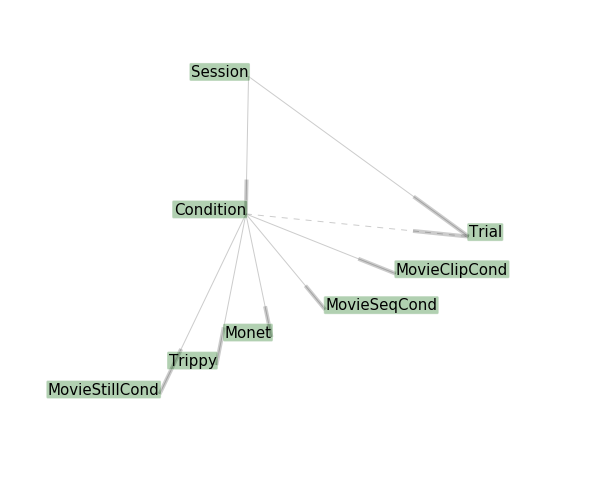

In [2]:
(dj.ERD(Session)+2).draw()


Each `vis.Session` comprises multiple trials that each has only one condition.  The trial has timing information and refers to the general stimulus condition.

---
The type of condition is determined by the dependent tables of `vis.Condition` (e.g. `vis.Monet`, `vis.Trippy`, `vis.MovieClipCond`) that describe details that are specific to each type of visual stimulus. Some of these tables have lookup tables with cached data-intensive stimuli such as noise movies.

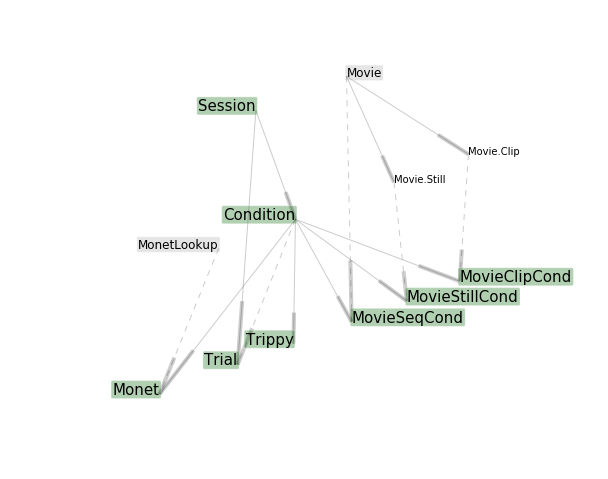

In [3]:
dj.ERD(schema).draw()

In [4]:
from pipeline import preprocess
preprocess.Sync().show_definition();

# 
-> Prepare
---
-> vis.Session
first_trial          : int                          # first trial index from psy.Trial overlapping recording
last_trial           : int                          # last trial index from psy.Trial overlapping recording
signal_start_time    : double                       # (s) signal start time on stimulus clock
signal_duration      : double                       # (s) signal duration on stimulus time
frame_times = null   : longblob                     # times of frames and slices
sync_ts = CURRENT_TIMESTAMP : timestamp                    # automatic



In [5]:
Trial().show_definition();

# visual stimulus trial
-> Session
trial_idx            : int                          # trial index within sessions
---
-> Condition
flip_times           : mediumblob                   # (s) row array of flip times
last_flip_count      : int unsigned                 # the last flip number in this trial
trial_ts = CURRENT_TIMESTAMP : timestamp                    # automatic



This way, joining `preprocess.Sync*vis.Trial` provides all the trials that were played for the given scan: 

In [6]:
keys = list(preprocess.Sync().fetch.keys())   # get keys for each trial
matched_trials = preprocess.Sync()*Trial() & 'trial_idx between first_trial and last_trial'
matched_trials & keys[10]    # get all trials for 11th scan in the list

animal_id,session,scan_idx,psy_id,trial_idx,first_trial,last_trial,signal_start_time,signal_duration,sync_ts,cond_idx,last_flip_count,trial_ts
7816,1,33,5,229,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,6,862152,2016-02-10 18:49:19
7816,1,33,5,230,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,18,865752,2016-02-10 18:50:19
7816,1,33,5,231,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,19,869352,2016-02-10 18:51:19
7816,1,33,5,232,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,12,872952,2016-02-10 18:52:19
7816,1,33,5,233,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,29,876552,2016-02-10 18:53:19
7816,1,33,5,234,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,9,880152,2016-02-10 18:54:19
7816,1,33,5,235,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,10,883752,2016-02-10 18:55:19


But how do you know which what kind of stimulus was displayed?

Each trial has only one stimulus condition.  That stimulus condition is only found in one of the condition tables.  So joining with the wrong kind of condition will yield an empty result and joining with the right table will return exactly one condition for each trial:

In [7]:
matched_trials * Trippy() & keys[10]   # wrong stimulus type

animal_id,session,scan_idx,psy_id,trial_idx,cond_idx,first_trial,last_trial,signal_start_time,signal_duration,sync_ts,last_flip_count,trial_ts,version,rng_seed,luminance,contrast,tex_ydim,tex_xdim,duration,frame_downsample,xnodes,ynodes,up_factor,temp_freq,temp_kernel_length,spatial_freq


In [8]:
matched_trials * Monet() & keys[10]   # right stimulus type

animal_id,session,scan_idx,psy_id,trial_idx,cond_idx,first_trial,last_trial,signal_start_time,signal_duration,sync_ts,last_flip_count,trial_ts,moving_noise_version,moving_noise_paramhash,rng_seed,luminance,contrast,tex_ydim,tex_xdim,spatial_freq_half,spatial_freq_stop,temp_bandwidth,ori_on_secs,ori_off_secs,n_dirs,ori_bands,ori_modulation,speed,frame_downsample
7816,1,33,5,229,6,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,862152,2016-02-10 18:49:19,5,c2277563f3,6.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1
7816,1,33,5,230,18,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,865752,2016-02-10 18:50:19,5,f68807a520,18.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1
7816,1,33,5,231,19,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,869352,2016-02-10 18:51:19,5,39f729e750,19.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1
7816,1,33,5,232,12,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,872952,2016-02-10 18:52:19,5,b74a487968,12.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1
7816,1,33,5,233,29,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,876552,2016-02-10 18:53:19,5,2fac2ad095,29.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1
7816,1,33,5,234,9,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,880152,2016-02-10 18:54:19,5,13c5d1ef96,9.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1
7816,1,33,5,235,10,229,258,1.45515e+09,1850.41,2016-07-07 14:15:20,883752,2016-02-10 18:55:19,5,0b0d9070e7,10.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1


In practice, such searching is rarely necessary.  Typically, you first decide what stimulus you want to work with and select the scans that have that stimulus.  This is the principle behind automated population of computed tables.

In [9]:
monet_scans = preprocess.Sync() & matched_trials*Monet() 
monet_scans.proj()   # display

animal_id,session,scan_idx
7588,1,4
7588,2,2
7816,1,11
7816,1,20
7816,1,24
7816,1,26
7816,1,27


In [10]:
monet_scan_keys = list(monet_scans.fetch.keys())  # the keys of all scans that had the monet stimulus

These keys can now be used to index scan information and the corresponding trials:

In [11]:
# monet trials with all relevant information for one scan.  Includes stimulus movie.
query = matched_trials*Monet()*MonetLookup() & monet_scan_keys[10]   

In [12]:
query.heading

animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
psy_id               : smallint unsigned            # unique psy session number
trial_idx            : int                          # trial index within sessions
cond_idx             : smallint unsigned            # condition index
moving_noise_version : smallint                     # algorithm version; increment when code changes
moving_noise_paramhash : char(10)                     # hash of the lookup parameters
---
first_trial          : int                          # first trial index from psy.Trial overlapping recording
last_trial           : int                          # last trial index from psy.Trial overlapping recording
signal_start_time    : double                       # (s) signal start time on stimulus clock
signal_duration      : double           

In [13]:
query

animal_id,session,scan_idx,psy_id,trial_idx,cond_idx,moving_noise_version,moving_noise_paramhash,first_trial,last_trial,signal_start_time,signal_duration,sync_ts,last_flip_count,trial_ts,rng_seed,luminance,contrast,tex_ydim,tex_xdim,spatial_freq_half,spatial_freq_stop,temp_bandwidth,ori_on_secs,ori_off_secs,n_dirs,ori_bands,ori_modulation,speed,frame_downsample,moving_noise_lookup_ts
7816,1,34,5,259,28,5,cfa6185f67,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,970152,2016-02-10 19:22:32,28.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 14:01:19
7816,1,34,5,260,20,5,175c826543,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,973752,2016-02-10 19:23:32,20.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:56:30
7816,1,34,5,261,3,5,209c12cf0f,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,977352,2016-02-10 19:24:32,3.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:45:48
7816,1,34,5,262,5,5,cf2270a1c3,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,980952,2016-02-10 19:25:32,5.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:46:59
7816,1,34,5,263,22,5,b2dab08578,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,984552,2016-02-10 19:26:32,22.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:57:40
7816,1,34,5,264,15,5,9955ec108a,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,988152,2016-02-10 19:27:32,15.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:53:20
7816,1,34,5,265,21,5,73a3b25df3,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,991752,2016-02-10 19:28:32,21.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:57:05


Next: [pipeline_preprocess](pipeline_preprocess.ipynb)